In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exponential_pdf(x, l=1):
    return l * np.exp(-l * x)

Analytical solution:

$$ \int_0^1 \lambda \cdot e^{-\lambda x} dx = -\lambda \cdot \frac{1}{\lambda} \cdot e^{-\lambda x} \Big|_0^1 = 1 - e^{-\lambda}$$


Compute an integral using the trapezoid rule
●Split the job between processes and use Reduce 
collective communication
●Check the accuracy when
taking more nodes
(i.e. smaller step)
●Check the speedup 
when taking more processes

In [3]:
l = 1
an_int = 1 - np.exp(-l)
print(f"Answer: {an_int}")

Answer: 0.6321205588285577


In [4]:
lin = np.linspace(0,1,10000)
trap_int = 0
for i in range(9999):
    trap_int += (exponential_pdf(lin[i]) + exponential_pdf(lin[i+1]))*(lin[i+1]-lin[i])/2
print(f"Answer: {trap_int}")

Answer: 0.6321205593554283


In [25]:
%%writefile test.py
from mpi4py import MPI
import numpy as np

def exponential_pdf(x, l=1):
    return l * np.exp(-l * x)

l = 1
an_int = 1 - np.exp(-l)

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

num_iter = 10000000

lin = np.linspace(0,1,num_iter)
trap_int = 0
for i in range(rank*(num_iter-1)//size, (rank+1)*(num_iter-1)//size):
    trap_int += (exponential_pdf(lin[i]) + exponential_pdf(lin[i+1]))*(lin[i+1]-lin[i])/2

recvbuf = comm.reduce(trap_int, op=MPI.SUM, root = 0)


end = MPI.Wtime()

if rank==0:
    print(recvbuf)
    print(end-start)
    print(abs(an_int - recvbuf))


Overwriting test.py


In [26]:
!mpirun --allow-run-as-root -n 1 python test.py

0.63212055882856
60.595270735999975
2.3314683517128287e-15


In [27]:
!mpirun --allow-run-as-root -n 2 python test.py

0.632120558828573
60.16472287200003
1.532107773982716e-14


In [28]:
!mpirun --allow-run-as-root -n 3 python test.py

0.6321205588285519
61.915537704999906
5.773159728050814e-15


In [29]:
!mpirun --allow-run-as-root -n 4 python test.py

0.6321205588285694
62.71136839600001
1.176836406102666e-14


In [30]:
!mpirun --allow-run-as-root -n 5 python test.py

0.632120558828561
61.276912270000025
3.3306690738754696e-15


In [31]:
!mpirun --allow-run-as-root -n 6 python test.py

0.6321205588285557
63.205188418000034
1.9984014443252818e-15


In [32]:
!mpirun --allow-run-as-root -n 7 python test.py

0.6321205588285541
63.988715497000044
3.552713678800501e-15


In [33]:
!mpirun --allow-run-as-root -n 8 python test.py

0.632120558828561
64.27261292399999
3.3306690738754696e-15


In [34]:
!mpirun --allow-run-as-root -n 9 python test.py

0.6321205588285544
63.306443884000146
3.219646771412954e-15


In [35]:
!mpirun --allow-run-as-root -n 10 python test.py

0.63212055882856
62.635657261000006
2.3314683517128287e-15


Text(0, 0.5, 'Speedup')

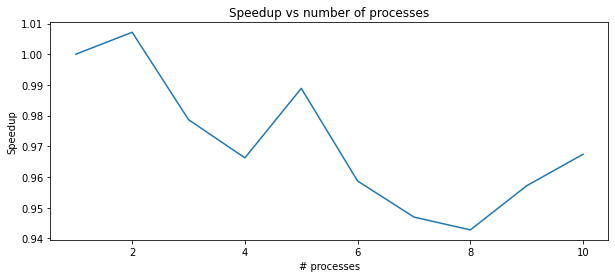

In [38]:
speedup = np.array([60.595270735999975,
                    60.16472287200003,
                    61.915537704999906,
                    62.71136839600001,
                    61.276912270000025,
                    63.205188418000034,
                    63.988715497000044,
                    64.27261292399999,
                    63.306443884000146,
                    62.635657261000006])
speedup = speedup[0] / speedup
plt.figure(figsize=(10,4))
plt.title('Speedup vs number of processes')
plt.plot(np.arange(1,11), speedup)
plt.xlabel('# processes')
plt.ylabel('Speedup')

In [54]:
%%writefile test.py
from mpi4py import MPI
import numpy as np

def exponential_pdf(x, l=1):
    return l * np.exp(-l * x)

l = 1
an_int = 1 - np.exp(-l)

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

num_iter = 10000000

lin = np.linspace(0,1,num_iter)
trap_int = 0
for i in range(rank*(num_iter-1)//size, (rank+1)*(num_iter-1)//size):
    trap_int += (exponential_pdf(lin[i]) + exponential_pdf(lin[i+1]))*(lin[i+1]-lin[i])/2

recvbuf = comm.reduce(trap_int, op=MPI.SUM, root = 0)


end = MPI.Wtime()

if rank==0:
    print(recvbuf)
    print(end-start)
    print(abs(an_int - recvbuf))


Overwriting test.py


In [55]:
!mpirun --allow-run-as-root -n 2 python test.py

0.632120558828573
63.743375044000004
1.532107773982716e-14


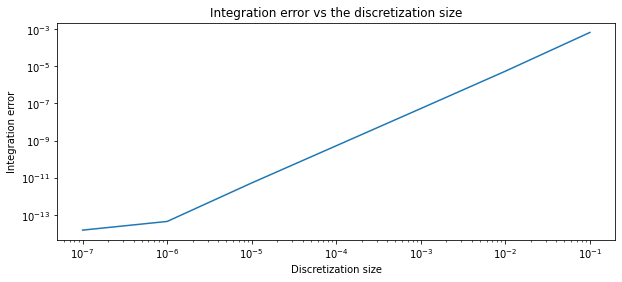

In [62]:
errors = np.array([0.0006501960196403367,
                    5.374617249143121e-06,
                    5.278222436899682e-08,
                    5.268727676366325e-10,
                    5.271116876315318e-12,
                    4.4853010194856324e-14,
                    1.532107773982716e-14])
plt.figure(figsize=(10,4))
plt.title('Integration error vs the discretization size')
plt.plot(1/(10**np.arange(1,8)), errors)
plt.xlabel('Discretization size')
plt.ylabel('Integration error')
plt.xscale('log')
plt.yscale('log')